## This notebook briefly documents how we aggregated the hazus vulnerability functions to 7 classes

- We accessed the hazus TC impact functions. However, these are way to detailed (>200 functions) for our purpose
- Thus we aggregated the to 7 subclasses (reinforced_concrete, reinforced_masonery, steel, wood, adobe, precast_concrete, other)
- For the aggregation, we first approximate the individual functions with a sigmoid type function (emanuel curve), then we draw the median of the parameters for each class. The min-max range allows us to keep some uncertainty.
- This allows us for a cheap way forward without much data handeling


In [4]:
# load libraries and data
#%% load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
#%% import data
DP = Path('/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/CAPRA_TC_impf/')
# load excel file
id_file = pd.read_excel(DP.joinpath('IF_TC_HAZUS_id.xlsx'), sheet_name='Sheet1')
tag_file = pd.read_excel(DP.joinpath('IF_TC_HAZUS_tag.xlsx'), sheet_name='Sheet1')
tag_file = tag_file.dropna(subset=['id'])
tag_agg = pd.read_csv(DP.joinpath('IF_TC_tag_agg.csv'))


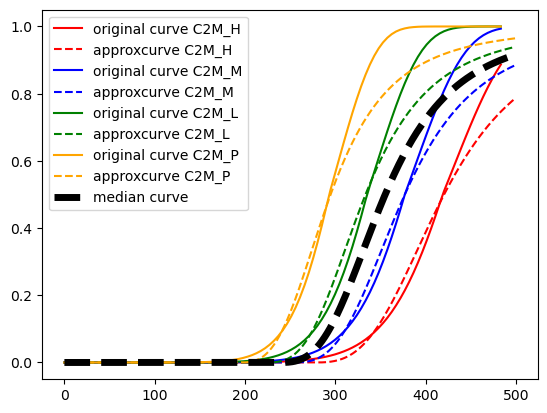

In [13]:
# repruduce curves for one building class
def sig_emanuel(x, v_thresh, v_half):
    v_temp = (x - v_thresh) / (v_half - v_thresh)
    v_temp[v_temp < 0] = 0
    y = v_temp**3 / (1 + v_temp**3)
    return y

cc = tag_file[tag_file['structural_sys'] == 'C2']
cc_uni = cc['tag'].unique()

cols = ['red', 'blue', 'green', 'orange']
v_halfs = np.zeros(len(cc_uni))
v_threshs = np.zeros(len(cc_uni))
xx = np.arange(0, 500, 1)

for t, tag in enumerate(cc_uni):
    impf = pd.read_excel(DP.joinpath('output/'+str(tag)+'.xlsx'), sheet_name='Sheet1')

    inten = impf.iloc[:,0]
    mdd = impf.iloc[:,1]
    v_halfs[t] = inten[np.argmin(np.abs(mdd - 0.5))]
    v_threshs[t] = inten[np.argmax(mdd > 0.01)]

    plt.plot(inten, mdd, color=cols[t], label='original curve'+ ' '+str(tag))

    yy = sig_emanuel(xx, v_threshs[t], v_halfs[t])
    plt.plot(xx,yy, color=cols[t], linestyle='dashed', label='approxcurve'+ ' '+str(tag))

y_main = sig_emanuel(xx, np.median(v_threshs), np.median(v_halfs))
plt.plot(xx, y_main, color='black', linestyle='dashed', linewidth=5, label='median curve')
plt.legend()
plt.show()